In [14]:
import numpy as np
import scipy.io as sio
import librosa as ls
from librosa.display import waveplot
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import os,re
from functools import partial

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from preprocessing import get_MFCC, split_signal, sound_pipeline, normalize_array, overlay_noise, add_padding_to_sound

In [7]:
df_voice=pd.read_pickle('df.pkl')
df_com = df_voice[df_voice.label.isin(['left','right','stop','go'])].reset_index(drop=True)
df_noise = df_voice[df_voice.label=='_background_noise_'].reset_index(drop=True)
df_noise = df_noise[df_noise.file!='dude_miaowing.wav'].reset_index(drop=True)

In [8]:
noise_classes = [n[:-4] for n in df_noise.file.to_list()]
noise_paths = df_noise.path.to_list()


noises = {}
for (noise_class, path) in zip(noise_classes, noise_paths):
    noise_sound, sr = ls.load(path)
    noises[noise_class] = split_signal(noise_sound, 22050,1)


In [9]:
noise_rates = {'doing_the_dishes': [0.03,0.05,0.07],
                 'exercise_bike': [0.03,0.05,0.07],
                 'pink_noise': [0.005,0.01,0.02],
                 'running_tap': [0.03,0.05,0.07],
                 'white_noise': [0.005,0.01,0.03]}

In [10]:
noise_name = 'running_tap'
short = df_com.sort_values(by=['sound_len']).iloc[25]
short_sound, sr = ls.load(short.path)
short_padded = add_padding_to_sound(short_sound)
short_noised = overlay_noise(short_padded, noises[noise_name][0], noiseRate=noise_rates[noise_name][0])

### Short

In [11]:
ipd.Audio(short_sound,rate=sr)

### Padded

In [12]:
ipd.Audio(short_padded,rate=sr)

### Noised

In [13]:
ipd.Audio(short_noised,rate=sr)

In [15]:

# sound, sr = ls.load(df_voice.iloc[0].path)
# mffc = sound_pipeline(sound,partial_mffc)
# print(np.min(mffc), np.max(mffc))

In [18]:
def get_rand_id(array):
    return np.random.randint(0,len(array))
def rand_element(arrayOfFrames):
    return arrayOfFrames[get_rand_id(arrayOfFrames)]
def overlay_rand_noise(sound, noises=noises, noise_rates = noise_rates, noiseLevel = 0):
    noise_class = rand_element(list(noise_rates.keys()))
    noiseRate = noise_rates[noise_class][noiseLevel]
    noiseFrames = noises[noise_class]
    randomNoised = overlay_noise(sound, rand_element(noiseFrames), noiseRate=noiseRate)
    return randomNoised



In [21]:
noise_name = 'running_tap'
short = df_com.sort_values(by=['sound_len']).iloc[25]
short_sound, sr = ls.load(short.path)
short_padded = add_padding_to_sound(short_sound)
short_noised = overlay_rand_noise(short_padded)
partial_mffc = partial(get_MFCC,sample_rate=22050,num_mfcc=13, n_fft=2048, hop_length=512, scaled = False)


<AxesSubplot:>

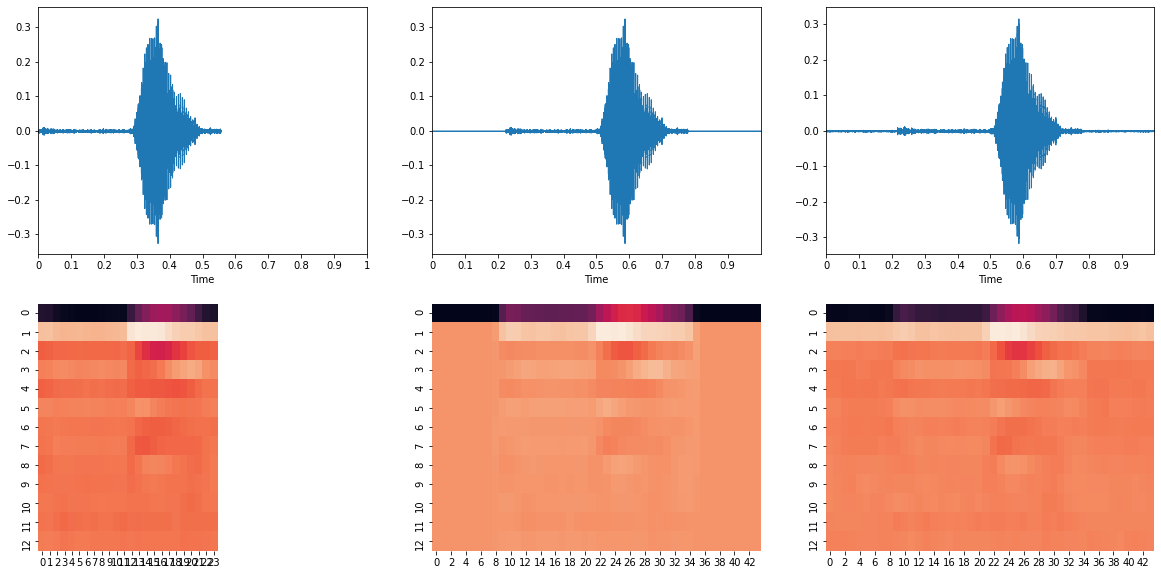

In [22]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
waveplot(short_sound, ax=axs[0][0])
axs[0][0].set_xlim([0,1])
waveplot(short_padded, ax=axs[0][1])
waveplot(short_noised, ax=axs[0][2])

sns.heatmap(partial_mffc(short_sound), ax=axs[1][0],cbar=False)
axs[1][0].set_xlim([0,44])
sns.heatmap(partial_mffc(short_padded), ax=axs[1][1],cbar=False)
sns.heatmap(partial_mffc(short_noised), ax=axs[1][2],cbar=False)


In [31]:
from IPython.display import clear_output
from file_operations import to_pickle, read_pickle


### Loading sound, padding and overlaying noise - creating raw/noised sound records dataset

In [33]:
com_paths = df_com.path.to_list()
com_labels = df_com.label.to_list()

sounds,labels,noiseLevels = [], [], []
for i, (path, label) in enumerate(zip(com_paths, com_labels)):
    clear_output(wait=True)
    sound, sr = ls.load(path)
    sound_len = len(sound)
    if sound_len<sr:
        sound = add_padding_to_sound(sound)
        lowNoised = overlay_rand_noise(sound)
        lowNoised = normalize_array(lowNoised)
        sounds.append(lowNoised),labels.append(label),noiseLevels.append('low')
    else:
        sound_normalized = normalize_array(sound)
        sounds.append(sound_normalized),labels.append(label),noiseLevels.append('no')

    for noise_class in noise_classes:
        midNoiseRate = noise_rates[noise_name][0]
        highNoiseRate = noise_rates[noise_name][0]
        noiseFrames = noises[noise_class]
        
        midNoised = overlay_noise(sound, rand_element(noiseFrames), noiseRate=midNoiseRate)
        highNoised = overlay_noise(sound, rand_element(noiseFrames), noiseRate=highNoiseRate)
        
        midNoised = normalize_array(midNoised)
        highNoised = normalize_array(highNoised)
        
        sounds.append(midNoised),labels.append(label),noiseLevels.append('mid')
        sounds.append(highNoised),labels.append(label),noiseLevels.append('high')
    print('Preprocessing progress {}%'.format(np.ceil(i/len(com_paths)*100)))

data = {'sounds':sounds, 'labels':labels,'noiseLevels':noiseLevels}
# to_pickle('costam.pickle', data)

In [34]:
data = read_pickle('com_sounds_nosed.pickle')

### Applying mfcc and creating imput to the neural net

In [41]:
partial_mffc = partial(get_MFCC,sample_rate=22050,num_mfcc=13, n_fft=2048, hop_length=512, scaled = False)
X = []
for i, s in enumerate(data['sounds']):
    clear_output(wait=True)
    X.append(partial_mffc(s))
    print('Preprocessing progress {}%'.format(np.ceil(i/len(data['sounds'])*100)))    

Preprocessing progress 100.0%


In [50]:
new_X = []
for x in X:
    new_X.append()

In [54]:
data['X'] = new_X

In [55]:
to_pickle('sample_rate2205_num_mfcc13_n_fft2048_hop_length512.pickle',data)